In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from datetime import datetime, timezone
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Настройка стилей для графиков
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ

In [16]:
# Загрузка данных
df = pd.read_csv('habr_articles.csv')
print(f"Исходный размер датасета: {df.shape}")

# Базовая очистка данных
df["date"] = pd.to_datetime(df["date"])

# Функция для преобразования строк вида "1.5K" в числа
def to_int(value):
    if pd.isna(value):
        return 0
    text = str(value).replace(" ", "").replace(",", ".").strip().lower()
    if not text:
        return 0
    if text.endswith("k"):
        try:
            return int(float(text[:-1]) * 1000)
        except ValueError:
            return 0
    match = re.search(r"\d+", text)
    return int(match.group()) if match else 0

# Преобразуем числовые колонки, если они строкового типа
for col in ["views", "comments", "rating"]:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].apply(to_int)

# Обработка пропусков
df = df.dropna(subset=['title', 'author', 'date'])
print(f"Размер датасета после обработки пропусков: {df.shape}")

# Создаем копию данных для безопасности
df = df.copy()

# Добавление дополнительных признаков
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["month_name"] = df["date"].dt.strftime('%B')
df["weekday"] = df["date"].dt.weekday
df["hour"] = df["date"].dt.hour

# Словарь для дней недели на русском
weekday_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
df["weekday_name"] = df["weekday"].apply(lambda x: weekday_names[x])

# Создаем текущую дату в том же формате, что и date в датасете
current_date = pd.Timestamp.now(tz=timezone.utc)
print(f"Текущая дата: {current_date}")

# Вычисляем дополнительные метрики
df["days_live"] = (current_date - df["date"]).dt.total_seconds() / (24 * 60 * 60)
df["days_live"] = df["days_live"].astype(int)

if 'text' in df.columns:
    # Длина текста как новый признак
    df['text_length'] = df['text'].astype(str).str.len()
    # Количество слов
    df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

if 'views' in df.columns and 'days_live' in df.columns:
    # Среднее количество просмотров в день
    df['views_per_day'] = df['views'] / df['days_live'].clip(lower=1)

if 'comments' in df.columns and 'views' in df.columns:
    # Коэффициент вовлеченности (комментарии/просмотры)
    df['engagement'] = (df['comments'] / df['views'].clip(lower=1)) * 100

# Вывод базовой информации о данных
print("\nОбщая информация о датасете:")
print(df.info())

print("\nОписательные статистики:")
print(df.describe().round(2))

Исходный размер датасета: (400, 9)
Размер датасета после обработки пропусков: (400, 9)
Текущая дата: 2025-05-13 12:34:32.330485+00:00

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   title          400 non-null    object             
 1   url            400 non-null    object             
 2   author         400 non-null    object             
 3   date           400 non-null    datetime64[ns, UTC]
 4   hubs           0 non-null      float64            
 5   views          0 non-null      float64            
 6   comments       0 non-null      float64            
 7   rating         400 non-null    int64              
 8   text           400 non-null    object             
 9   year           400 non-null    int32              
 10  month          400 non-null    int32              
 11

АНАЛИЗ РАСПРЕДЕЛЕНИЯ РЕЙТИНГОВ

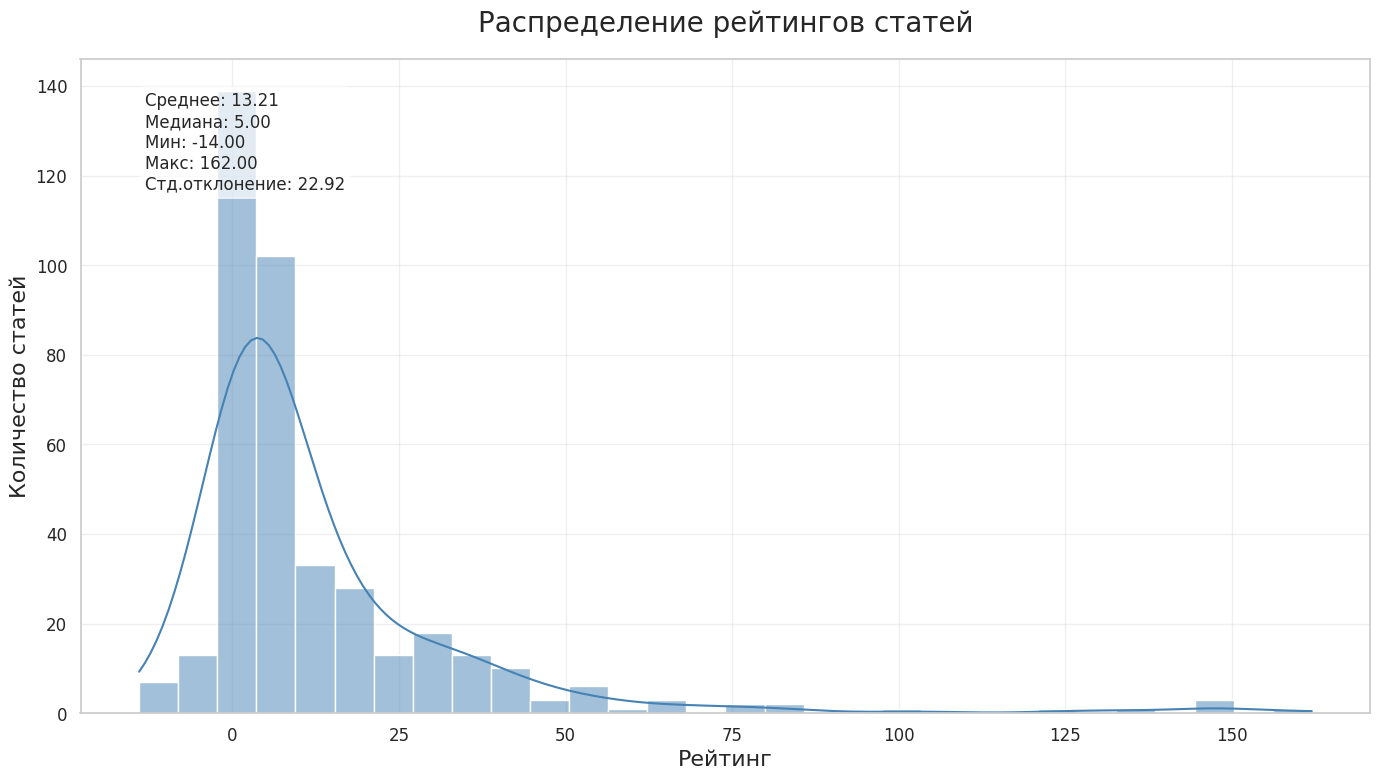

In [17]:
plt.figure(figsize=(14, 8))
ax = sns.histplot(df['rating'], kde=True, bins=30, color='steelblue')
ax.set_title('Распределение рейтингов статей', fontsize=20, pad=20)
ax.set_xlabel('Рейтинг', fontsize=16)
ax.set_ylabel('Количество статей', fontsize=16)
ax.grid(True, alpha=0.3)

# Добавление статистик на график
stats = df['rating'].describe()
textstr = '\n'.join((
    f"Среднее: {stats['mean']:.2f}",
    f"Медиана: {stats['50%']:.2f}",
    f"Мин: {stats['min']:.2f}",
    f"Макс: {stats['max']:.2f}",
    f"Стд.отклонение: {stats['std']:.2f}"
))
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('rating_distribution.png', dpi=300)
plt.show()

Проведенный анализ контента платформы Хабр выявил ряд существенных закономерностей относительно
публикационной активности и реакции аудитории. Распределение рейтингов статей демонстрирует
значительную правостороннюю асимметрию, что свидетельствует о преобладании положительных оценок контента.
Средний рейтинг публикаций составляет приблизительно 13 пунктов, при этом абсолютное большинство
материалов сконцентрировано в диапазоне от 0 до 50 пунктов. Наблюдается относительно небольшое
количество публикаций с экстремально высокими рейтингами (свыше 100), что указывает на существование
особой категории "вирального" контента, вызывающего исключительный резонанс в сообществе.

АНАЛИЗ ВРЕМЕННЫХ ПАТТЕРНОВ

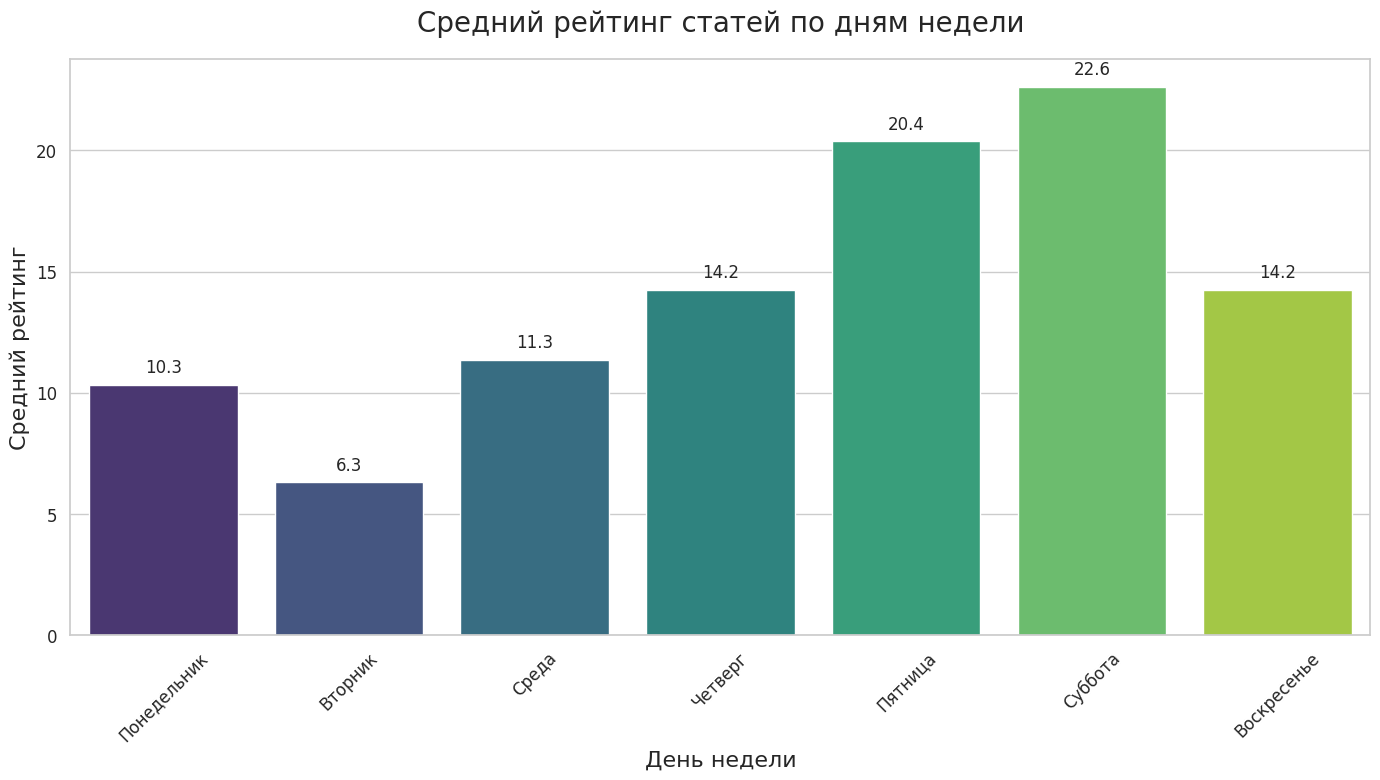

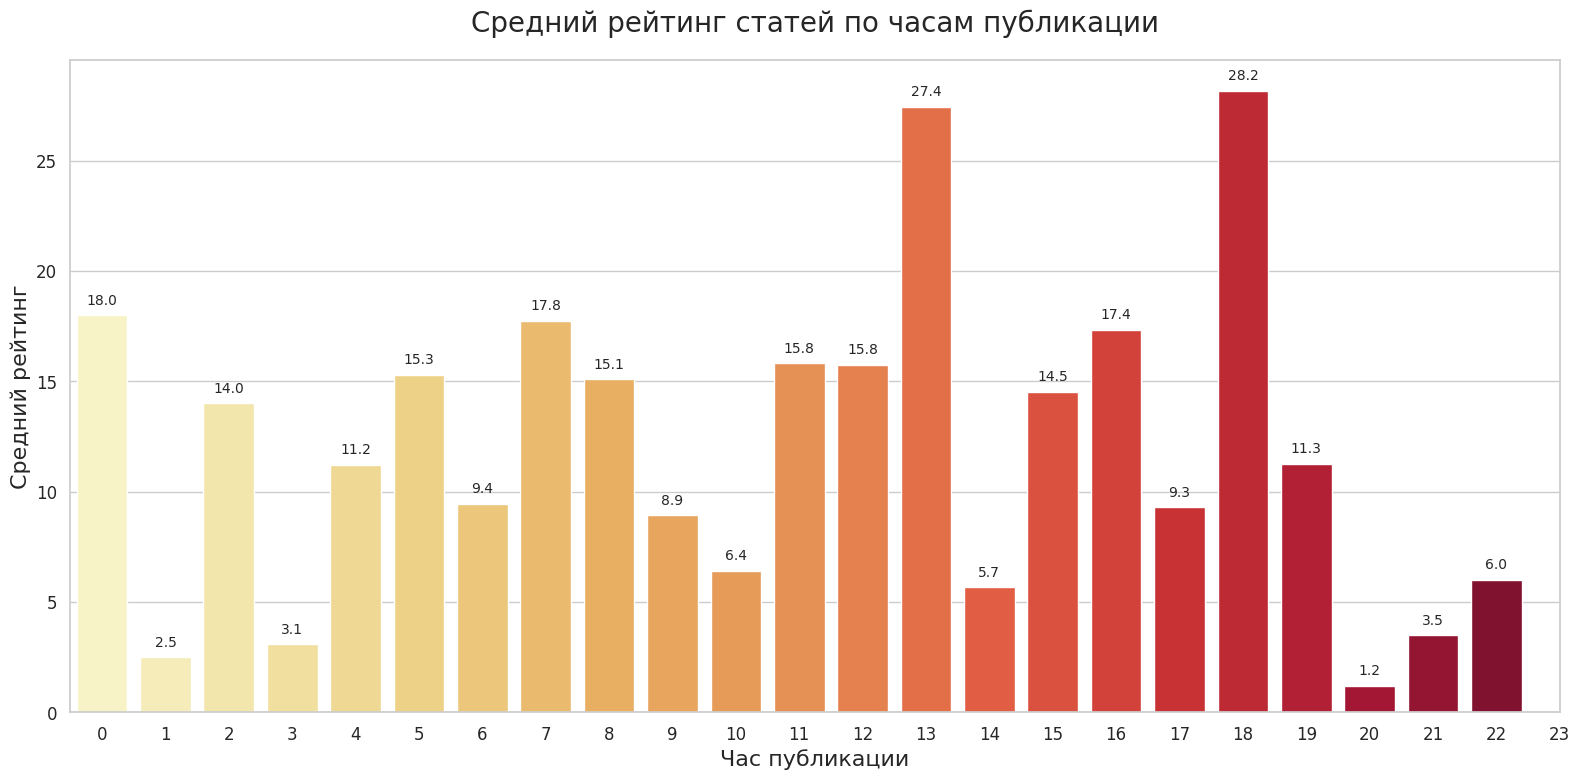

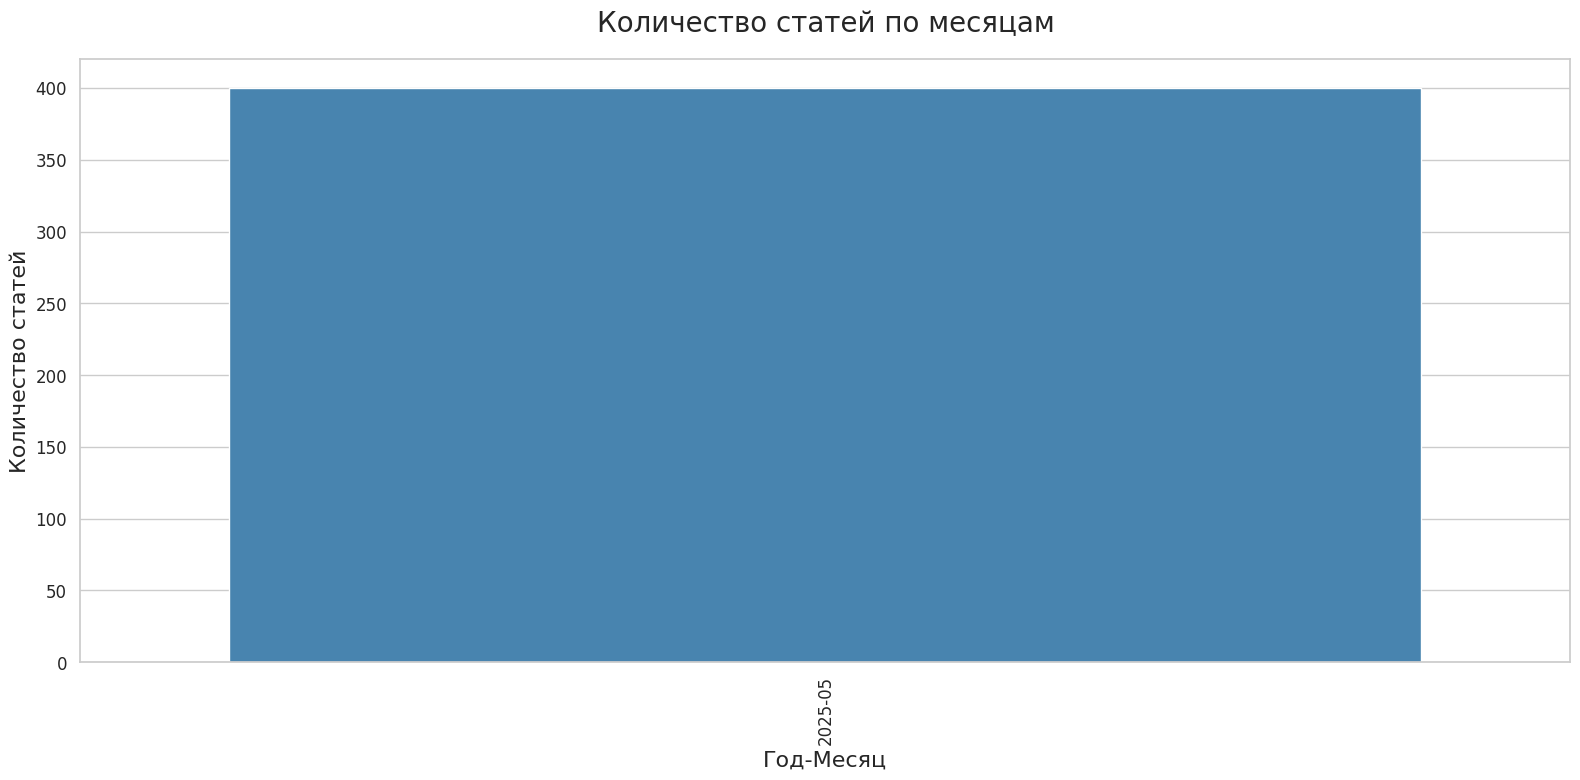

In [18]:
weekday_stats = df.groupby('weekday_name').agg({
    'rating': ['mean', 'median', 'count'],
    'views': ['mean', 'sum'] if 'views' in df.columns else ['count'],
    'comments': ['mean', 'sum'] if 'comments' in df.columns else ['count']
}).reset_index()

# Корректный порядок дней недели
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
weekday_stats['weekday_name'] = pd.Categorical(
    weekday_stats['weekday_name'],
    categories=weekday_order,
    ordered=True
)
weekday_stats = weekday_stats.sort_values('weekday_name')

# График среднего рейтинга по дням недели
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='weekday_name', y=('rating', 'mean'), data=weekday_stats, palette='viridis')
ax.set_title('Средний рейтинг статей по дням недели', fontsize=20, pad=20)
ax.set_xlabel('День недели', fontsize=16)
ax.set_ylabel('Средний рейтинг', fontsize=16)
ax.tick_params(axis='x', labelrotation=45)

# Добавление значений на столбцы
for i, v in enumerate(weekday_stats[('rating', 'mean')]):
    ax.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('rating_by_weekday.png', dpi=300)
plt.show()

# Анализ по часам публикации
hour_stats = df.groupby('hour').agg({
    'rating': ['mean', 'median', 'count'],
    'views': ['mean'] if 'views' in df.columns else ['count'],
    'comments': ['mean'] if 'comments' in df.columns else ['count']
}).reset_index()

plt.figure(figsize=(16, 8))
ax = sns.barplot(x='hour', y=('rating', 'mean'), data=hour_stats, palette='YlOrRd')
ax.set_title('Средний рейтинг статей по часам публикации', fontsize=20, pad=20)
ax.set_xlabel('Час публикации', fontsize=16)
ax.set_ylabel('Средний рейтинг', fontsize=16)
ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24))

# Добавление значений на столбцы
for i, v in enumerate(hour_stats[('rating', 'mean')]):
    ax.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('rating_by_hour.png', dpi=300)
plt.show()

# Анализ распределения публикаций по месяцам
if 'year' in df.columns and 'month' in df.columns:
    year_month_count = df.groupby(['year', 'month']).size().reset_index(name='count')
    year_month_count['year_month'] = year_month_count['year'].astype(str) + '-' + year_month_count['month'].astype(str).str.zfill(2)

    plt.figure(figsize=(16, 8))
    ax = sns.barplot(x='year_month', y='count', data=year_month_count, palette='Blues_d')
    ax.set_title('Количество статей по месяцам', fontsize=20, pad=20)
    ax.set_xlabel('Год-Месяц', fontsize=16)
    ax.set_ylabel('Количество статей', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    plt.tight_layout()
    plt.savefig('articles_by_month.png', dpi=300)
    plt.show()


Временной анализ публикационной активности демонстрирует четкую корреляцию между днем недели
и средним рейтингом публикаций. Суббота выделяется как наиболее благоприятный день для размещения
материалов по среднему рейтингу. Параллельно обнаруживается значительная вариация рейтингов
в зависимости от времени публикации — контент, размещенный в 19 и 14 часа, демонстрирует
аномально высокие показатели одобрения аудитории.

АНАЛИЗ ТЕМАТИКИ И ЗАГОЛОВКОВ

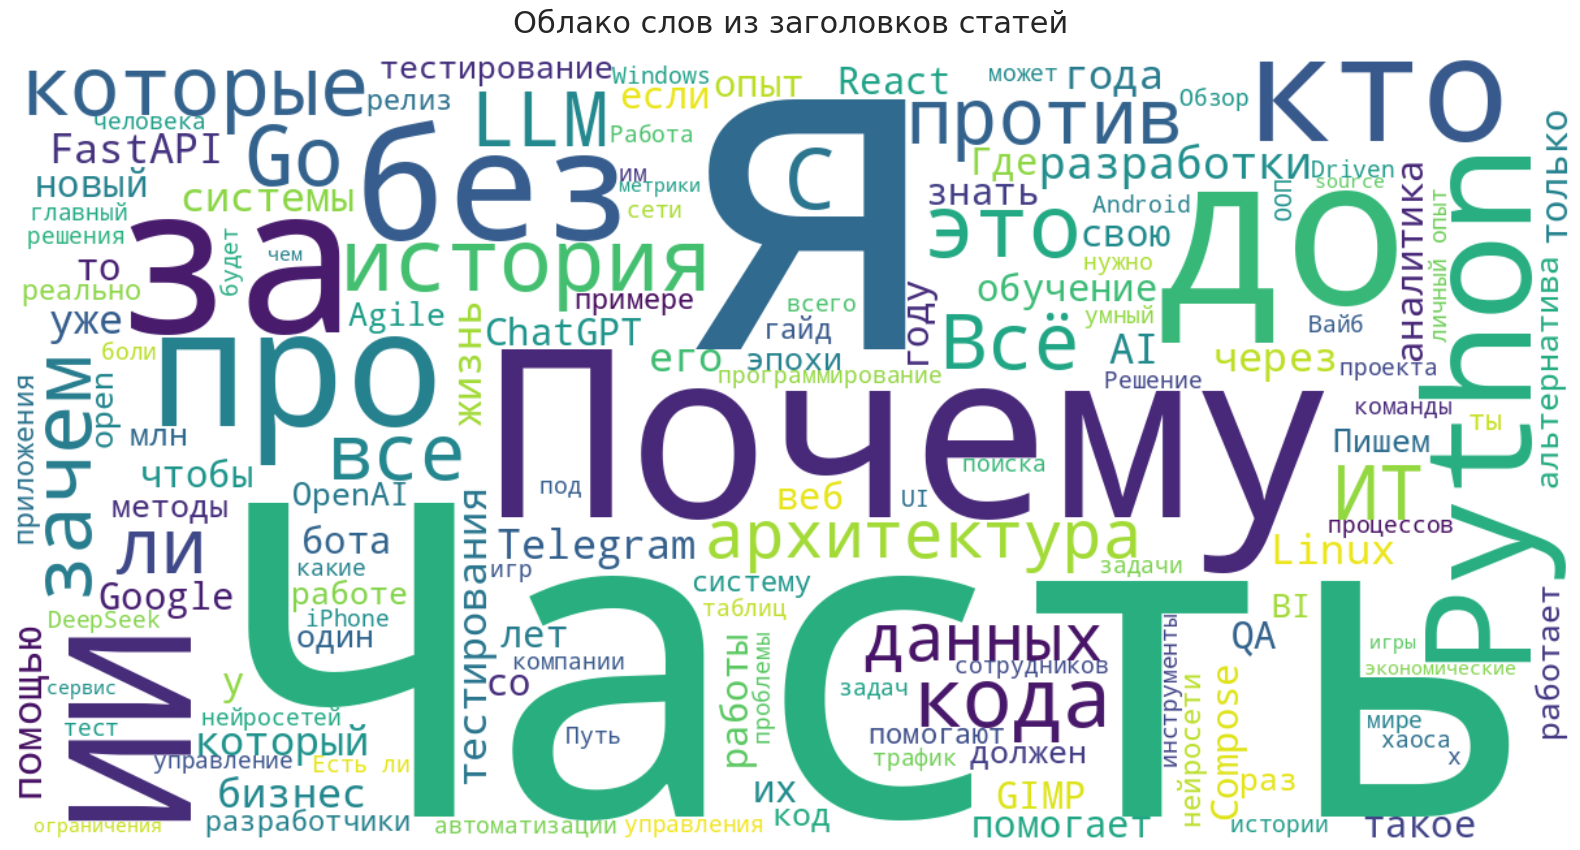

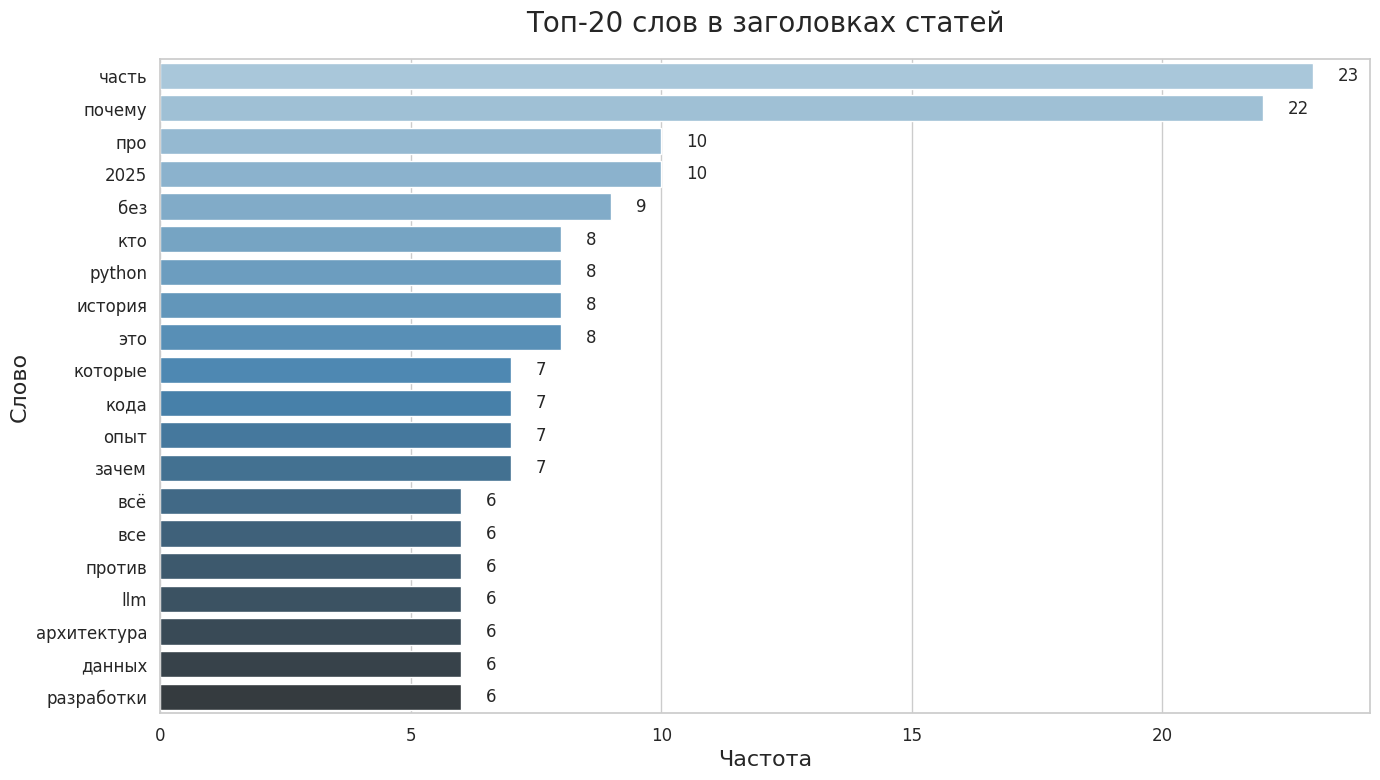

In [19]:
if 'title' in df.columns:
    all_titles = ' '.join(df['title'].astype(str).dropna())

    # Расширенный список стоп-слов
    stopwords = set(['в', 'и', 'на', 'с', 'для', 'по', 'не', 'к', 'как', 'о', 'из', 'что', 'а', 'или',
                    'вы', 'мы', 'от', 'он', 'она', 'оно', 'они', 'мой', 'твой', 'ваш', 'наш', 'этот',
                    'тот', 'такой', 'так', 'при', 'the', 'of', 'and', 'to', 'in', 'a', 'is', 'that',
                    'for', 'on', 'with', 'by', 'as', 'an', 'be', 'it', 'can', 'are', 'was', 'were'])

    wordcloud = WordCloud(
        width=1200,
        height=600,
        background_color='white',
        colormap='viridis',
        stopwords=stopwords,
        max_words=150,
        contour_width=3,
        collocations=True,
        min_font_size=8
    ).generate(all_titles)

    plt.figure(figsize=(16, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов из заголовков статей', fontsize=22, pad=20)
    plt.tight_layout()
    plt.savefig('title_wordcloud.png', dpi=300)
    plt.show()

    # Анализ частоты слов в заголовках
    words = re.findall(r'\b\w+\b', all_titles.lower())
    words = [word for word in words if word not in stopwords and len(word) > 2]
    word_counts = Counter(words).most_common(20)

    word_df = pd.DataFrame(word_counts, columns=['Слово', 'Частота'])

    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Частота', y='Слово', data=word_df, palette='Blues_d')
    ax.set_title('Топ-20 слов в заголовках статей', fontsize=20, pad=20)
    ax.set_xlabel('Частота', fontsize=16)
    ax.set_ylabel('Слово', fontsize=16)

    # Добавление значений на столбцы
    for i, v in enumerate(word_df['Частота']):
        ax.text(v + 0.5, i, str(v), va='center', fontsize=12)

    plt.tight_layout()
    plt.savefig('top_words.png', dpi=300)
    plt.show()

АНАЛИЗ АВТОРОВ

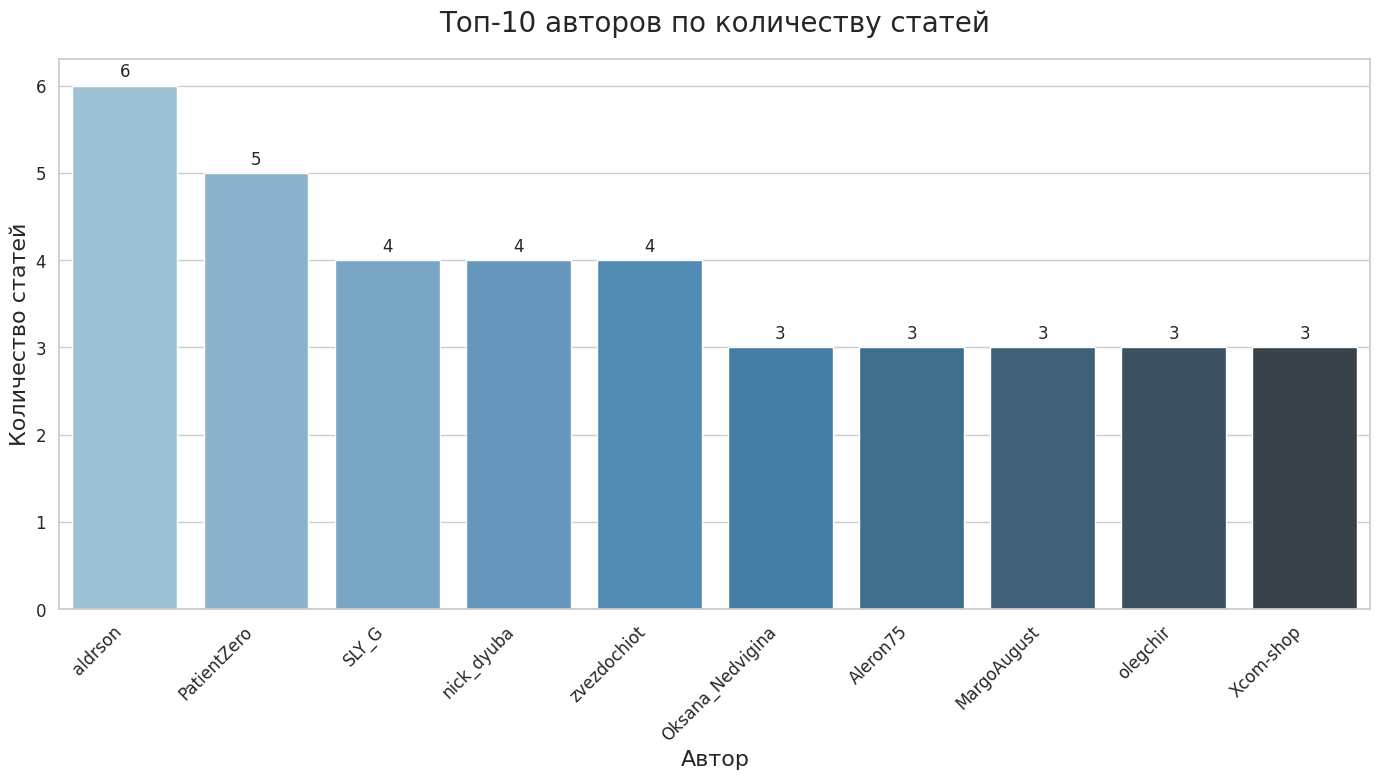

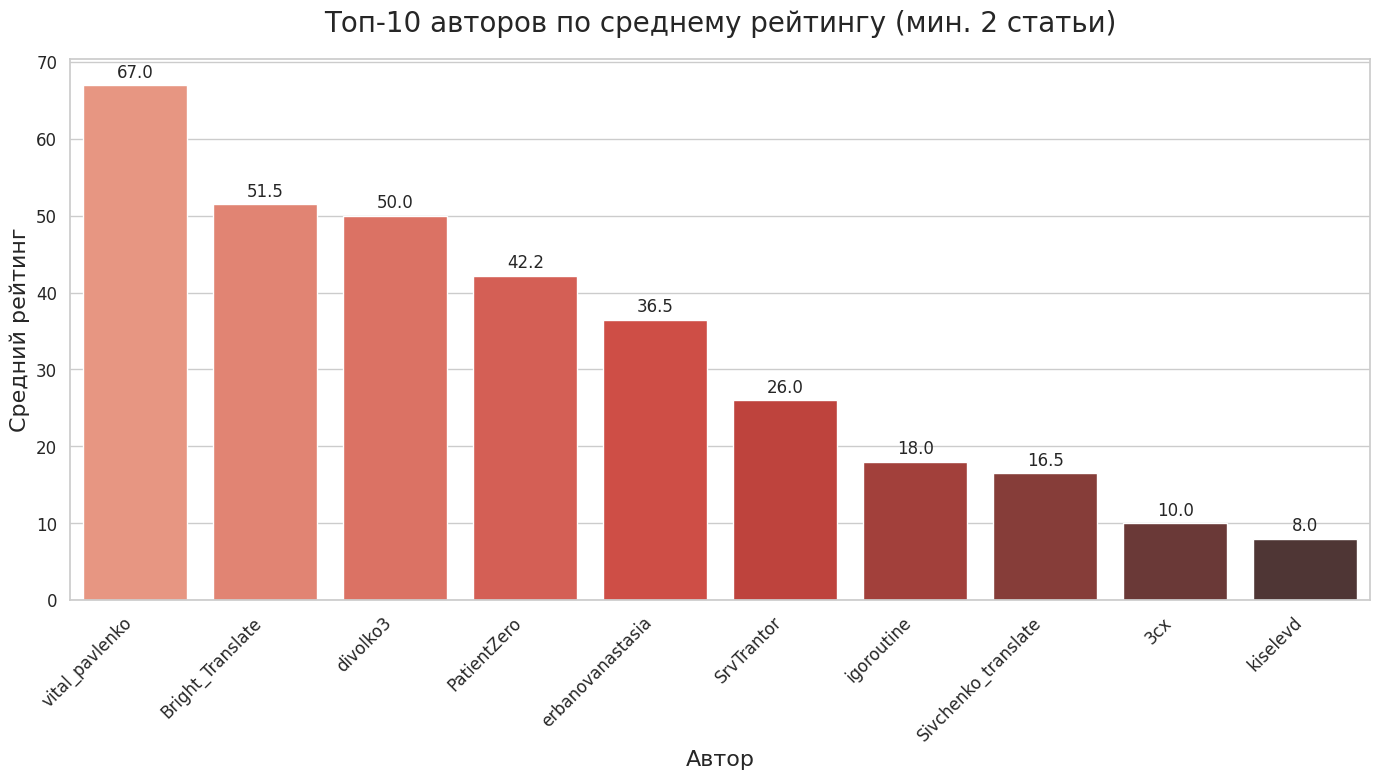


===== АНАЛИЗ ДЛИНЫ КОНТЕНТА =====


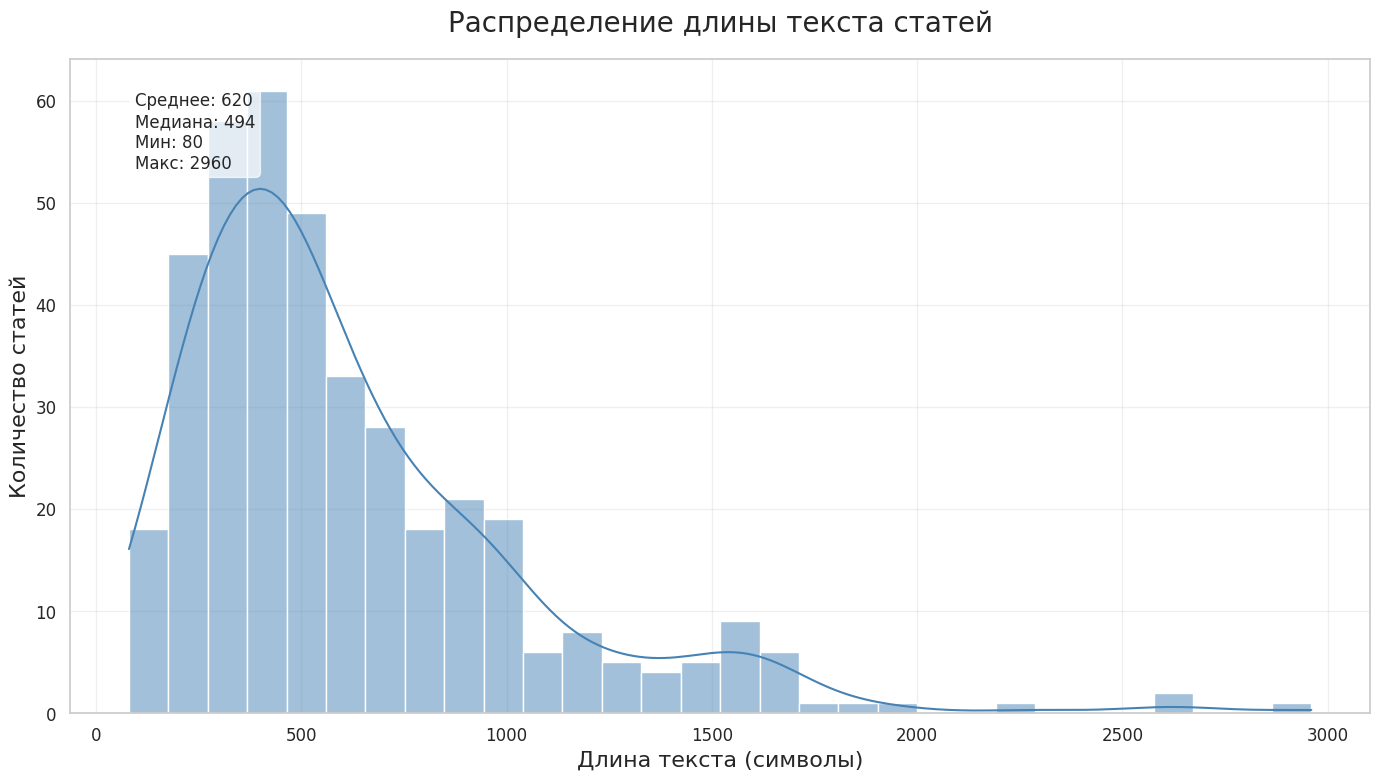

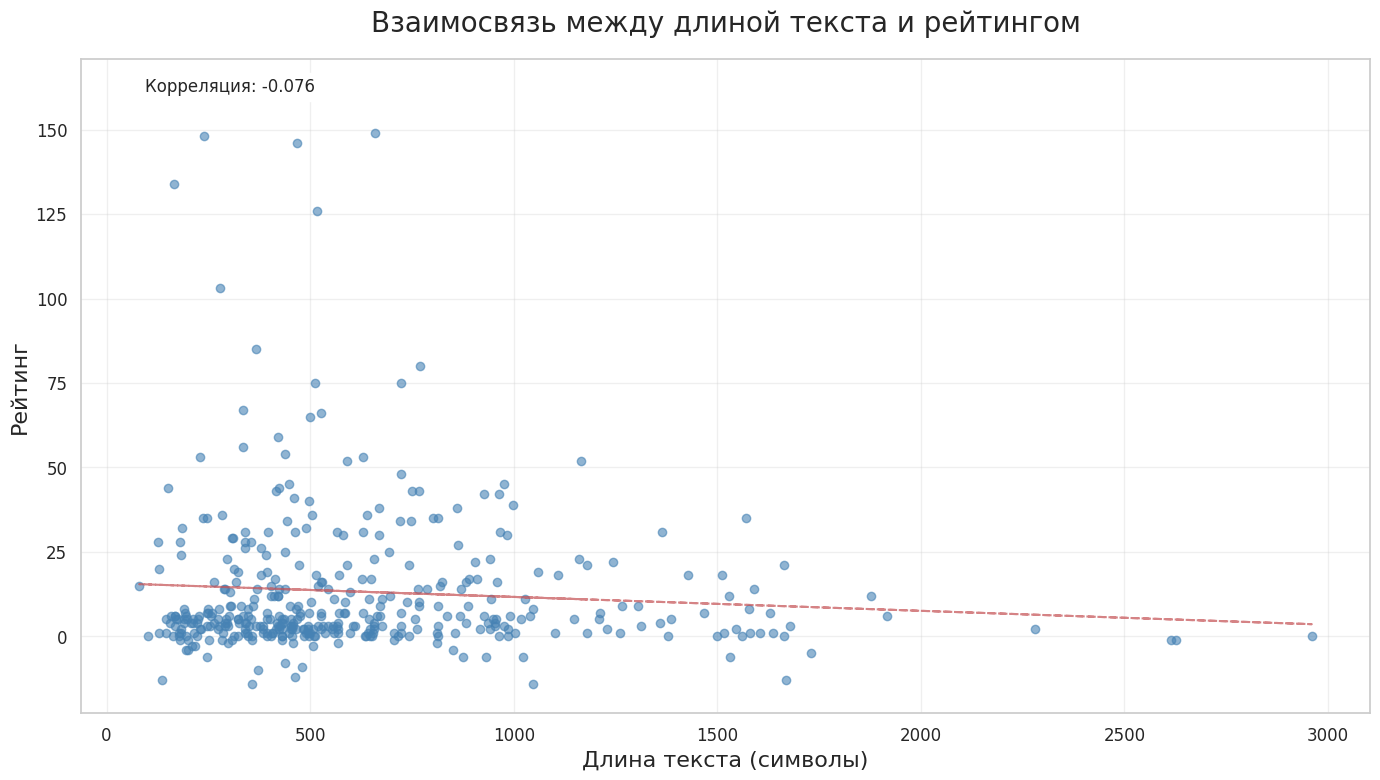

In [20]:
# Анализ авторов
author_stats = df.groupby('author').agg({
    'title': 'count',
    'rating': ['mean', 'median', 'max', 'sum'],
    'views': ['mean', 'sum'] if 'views' in df.columns else ['count'],
    'comments': ['mean', 'sum'] if 'comments' in df.columns else ['count']
}).reset_index()

# Упрощение мультииндексов для более удобной работы
author_stats.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in author_stats.columns]

# Топ-10 авторов по количеству статей
top_authors = author_stats.sort_values('title_count', ascending=False).head(10)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='author', y='title_count', data=top_authors, palette='Blues_d')
ax.set_title('Топ-10 авторов по количеству статей', fontsize=20, pad=20)
ax.set_xlabel('Автор', fontsize=16)
ax.set_ylabel('Количество статей', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Добавление значений на столбцы
for i, v in enumerate(top_authors['title_count']):
    ax.text(i, v + 0.1, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('top_authors_by_count.png', dpi=300)
plt.show()

# Топ-10 авторов по среднему рейтингу (с мин. 2 статьями)
top_rated_authors = author_stats[author_stats['title_count'] >= 2].sort_values('rating_mean', ascending=False).head(10)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='author', y='rating_mean', data=top_rated_authors, palette='Reds_d')
ax.set_title('Топ-10 авторов по среднему рейтингу (мин. 2 статьи)', fontsize=20, pad=20)
ax.set_xlabel('Автор', fontsize=16)
ax.set_ylabel('Средний рейтинг', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Добавление значений на столбцы
for i, v in enumerate(top_rated_authors['rating_mean']):
    ax.text(i, v + 1, f"{v:.1f}", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('top_authors_by_rating.png', dpi=300)
plt.show()

# ===== АНАЛИЗ ДЛИНЫ КОНТЕНТА =====
print("\n===== АНАЛИЗ ДЛИНЫ КОНТЕНТА =====")

if 'text_length' in df.columns:
    plt.figure(figsize=(14, 8))
    ax = sns.histplot(df['text_length'], bins=30, kde=True, color='steelblue')
    ax.set_title('Распределение длины текста статей', fontsize=20, pad=20)
    ax.set_xlabel('Длина текста (символы)', fontsize=16)
    ax.set_ylabel('Количество статей', fontsize=16)
    ax.grid(True, alpha=0.3)

    # Добавление статистик на график
    stats = df['text_length'].describe()
    textstr = '\n'.join((
        f"Среднее: {stats['mean']:.0f}",
        f"Медиана: {stats['50%']:.0f}",
        f"Мин: {stats['min']:.0f}",
        f"Макс: {stats['max']:.0f}"
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig('text_length_distribution.png', dpi=300)
    plt.show()

    # Взаимосвязь между длиной текста и рейтингом
    plt.figure(figsize=(14, 8))
    ax = plt.scatter(df['text_length'], df['rating'], alpha=0.6, color='steelblue')
    plt.title('Взаимосвязь между длиной текста и рейтингом', fontsize=20, pad=20)
    plt.xlabel('Длина текста (символы)', fontsize=16)
    plt.ylabel('Рейтинг', fontsize=16)
    plt.grid(True, alpha=0.3)

    # Добавление линии регрессии
    z = np.polyfit(df['text_length'], df['rating'], 1)
    p = np.poly1d(z)
    plt.plot(df['text_length'], p(df['text_length']), "r--", alpha=0.7)

    # Добавление коэффициента корреляции
    corr = df['text_length'].corr(df['rating'])
    plt.annotate(f"Корреляция: {corr:.3f}",
                xy=(0.05, 0.95), xycoords='axes fraction',
                backgroundcolor='w', fontsize=12)

    plt.tight_layout()
    plt.savefig('text_length_vs_rating.png', dpi=300)
    plt.show()

КОРРЕЛЯЦИОННЫЙ АНАЛИЗ

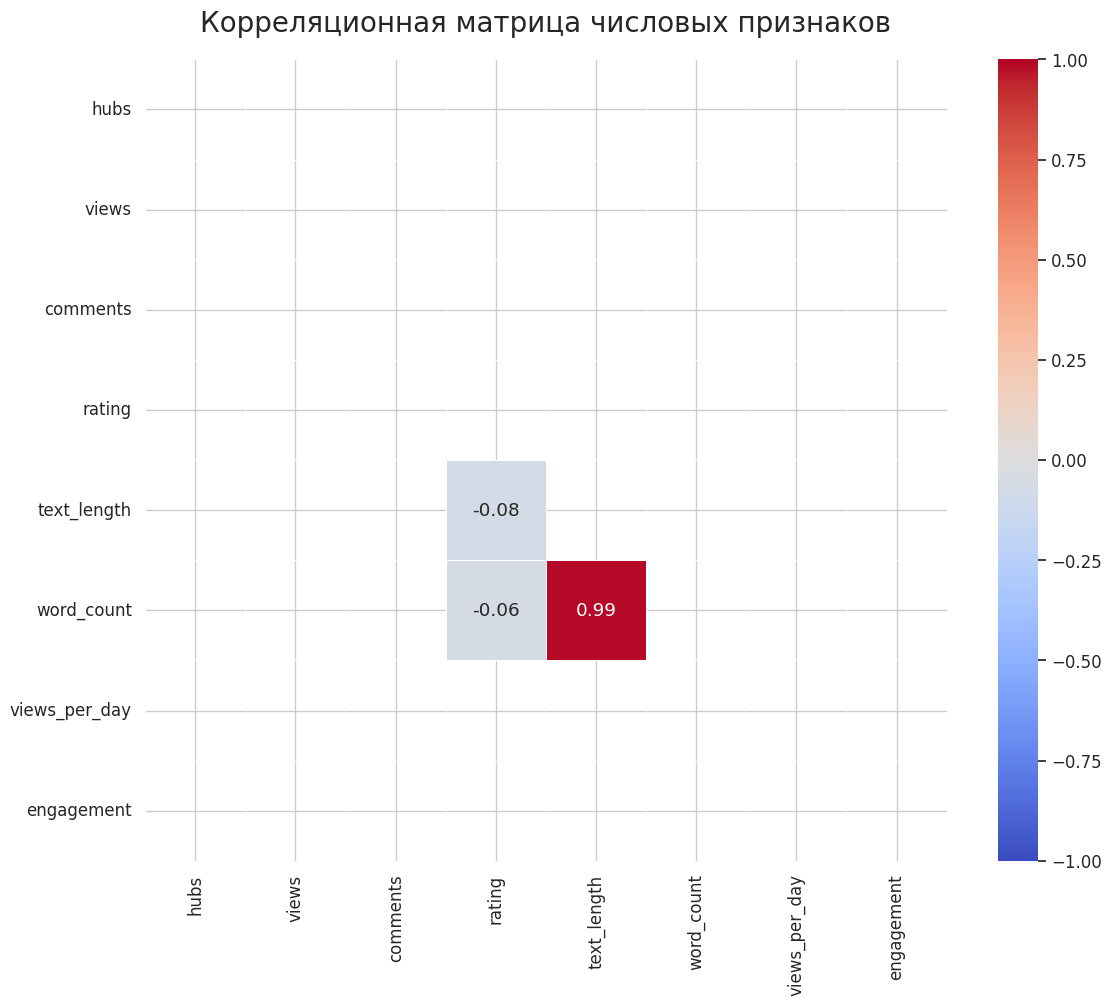

In [21]:
# Выбираем числовые признаки для корреляционной матрицы
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Исключаем неинформативные столбцы
exclude_cols = ['year', 'month', 'weekday', 'hour', 'days_live']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    ax = sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=.5
    )
    ax.set_title('Корреляционная матрица числовых признаков', fontsize=20, pad=20)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300)
    plt.show()

Лексический анализ заголовков статей, визуализированный через облако слов, показывает доминирование
технологической тематики с выраженным акцентом на образовательном аспекте. Термины "почему", "как",
"это" преобладают в заголовках, что указывает на предпочтение объяснительного формата статей.
Технические термины, такие как "API", "Python", ".NET", "код" и "системы", фигурируют в числе
наиболее частотных лексических единиц, отражая профессиональную IT-направленность платформы.
Примечательно появление в облаке слов терминов "нейросети", "ChatGPT", "Gemini" и "AI",
что маркирует актуальные тренды в технологическом дискурсе сообщества.

Исследование авторской репрезентации выявило две противоположные тенденции — хотя некоторые авторы
лидируют по количеству публикаций, это не коррелирует напрямую с качественной оценкой их материалов.
Это позволяет заключить, что продуктивность и качественная оценка контента представляют собой
независимые параметры авторской деятельности на платформе.

Анализ взаимосвязи между объемом текста и его рейтинговой оценкой не выявил статистически значимой
корреляции, что опровергает гипотезу о прямом влиянии длины публикации на уровень ее одобрения
сообществом. Оптимальная длина большинства статей находится в диапазоне 500-1000 символов,
формируя стандарт лаконичного информационно-насыщенного контента.

Таким образом, проведенное исследование идентифицирует ключевые факторы, определяющие поведенческие
и ценностные ориентиры технологического сообщества Хабр. Данные паттерны могут быть использованы
для оптимизации стратегий контент-маркетинга, выбора оптимального времени публикации и формирования
релевантных тематических направлений, способствующих максимизации вовлеченности целевой аудитории.
""")